In [59]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans,  MeanShift, DBSCAN , estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import entropy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
from sklearn.neighbors import NearestNeighbors


In [2]:
# 공통전처리된 df 불러옴
df = pd.read_csv(r'/Users/leeseohyun/Downloads/semi_project_code/after_kakao_preprocess.csv')
df.head()

,id,service_type,address1,address2,_floor,size_m2,sales_type,rent,deposit,manage_cost,...,ssg_ppltn,convenience_per_ppltn,shopping_per_ppltn,grocery_per_ppltn,restaurant_per_ppltn,medical_per_ppltn,culture_per_ppltn,gym_per_ppltn,ppltn_net_migration_rate,safety_idx
0,36293764,원룸,경기도 동두천시 생연동,225-16,3,24.79,월세,28,300,7.0,...,89914.0,57.833,142.358,330.316,1593.745,316.97,25.58,93.423,-0.043,24.0
1,36576214,원룸,경기도 동두천시 생연동,678-90,5,16.53,월세,30,300,5.0,...,89914.0,57.833,142.358,330.316,1593.745,316.97,25.58,93.423,-0.043,24.0
2,36533474,원룸,경기도 동두천시 생연동,678-56,6,43.87,월세,50,500,5.0,...,89914.0,57.833,142.358,330.316,1593.745,316.97,25.58,93.423,-0.043,24.0
3,36485939,빌라,경기도 동두천시 보산동,392-4,3,72.73,월세,110,3000,5.0,...,89914.0,57.833,142.358,330.316,1593.745,316.97,25.58,93.423,-0.043,24.0
4,36485528,원룸,경기도 동두천시 생연동,635-7,4,23.14,월세,40,500,5.0,...,89914.0,57.833,142.358,330.316,1593.745,316.97,25.58,93.423,-0.043,24.0


# 전처리

In [3]:
def drop_columns(dataframe):
    drop_column = [
        'id',
        'address1',
        'address2',
        'manage_cost_inc',
        'images',
        'near_subways',
        'options',
        'description',
        'title',
        'add1',
        'add2',
        'add3',
        'x_w84',
        'y_w84',
        'sgg_cd',
        'emd_cd_2022',
        'emd_cd_2020',
        'sido_nm',
        'sgg_nm',
        'emd_nm',
        'building_total',
        'ppltn_total',
        'ppltn_upper_65_p',
        'hhd_total',
        'sgg_cd',
        'sido_nm',
        'sgg_nm',
        'tenure_total',
        'tenure_self',
        'tenure_jeonse',
        'tenure_free',
        'tenure_monthly',
        'app_dasedae',
        'app_dandok',
        'app_nonresidential',
        'app_apt',
        'app_yeonlip',
        'app_officetel',
        'park_per_area',
        'green_per_area',
        'dust_level',
        'ssg_ppltn',
        'convenience_per_ppltn',
        'shopping_per_ppltn',
        'grocery_per_ppltn',
        'restaurant_per_ppltn',
        'medical_per_ppltn',
        'culture_per_ppltn',
        'gym_per_ppltn',
        'ppltn_net_migration_rate',
        'hhd_member_avg',
        'rent',
        'deposit',
        'manage_cost'
    ]
    return dataframe.drop(drop_column, axis=1)


In [4]:
def preprocess_cluster(dataframe):
    df_copy = dataframe.copy()
    df_drop = drop_columns(df_copy)

    # One-Hot Encoding
    df_ohe = pd.get_dummies(df_drop, columns=['service_type', 'room_direction_text', 'sales_type'], drop_first=False)
    
    # 지역 안전지수 범주화 
    safety_range = list(range(7, 28))

    safety_df = pd.DataFrame(safety_range, columns=['safety_value'])

    percentiles = [0.10, 0.35, 0.65, 0.90, 1]

    safety_list = safety_df['safety_value'].quantile(percentiles).tolist()

    for i in range(len(df_ohe)):
        for j in range(len(safety_list)):
            if df_ohe['safety_idx'][i] <= safety_list[j]:
                df_ohe['safety_idx'][i] = j
                break

    return df_ohe

service_type별 df 나누기

In [5]:
def service_type_sep(dataframe):
    df_ohe = preprocess_cluster(dataframe)
    
    villa_df = df_ohe[df_ohe['service_type_빌라'] == 1]
    oneroom_df = df_ohe[df_ohe['service_type_원룸'] == 1]
    officetel_df = df_ohe[df_ohe['service_type_오피스텔'] == 1]

    villa_drop_df = villa_df.drop(['service_type_빌라','service_type_오피스텔','service_type_원룸'], axis=1)
    oneroom_drop_df = oneroom_df.drop(['service_type_빌라','service_type_오피스텔','service_type_원룸'], axis=1)
    officetel_drop_df = officetel_df.drop(['service_type_빌라','service_type_오피스텔','service_type_원룸'], axis=1)

    return villa_drop_df, oneroom_drop_df, officetel_drop_df

# Model Parameter 

In [8]:
def make_scaled_df(dataframe):

    df_ohe = preprocess_cluster(dataframe)

    standard_scaler = StandardScaler()
    standard_df = standard_scaler.fit_transform(df_ohe)

    minmax_scaler = MinMaxScaler() 
    minmax_df = minmax_scaler.fit_transform(df_ohe) 

    robust_scaler = RobustScaler()
    robust_df = robust_scaler.fit_transform(df_ohe)

    return standard_df, minmax_df, robust_df, df_ohe

In [9]:
# 주성분 고윳값, 기여율, 누적기여율 확인 (scree plot)
# 군집 개수 정하기 (Elbow Method)

In [49]:
def num_of_components(dataframe):
    standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(dataframe)

    df_list = [df_ohe, standard_df, minmax_df, robust_df]
    df_name_list = ['Data Unscaled', 'Data Standard Scaled', 'Data Minmax Scaled', 'Data Robust Scaled']

    result_list = []

    for i in range(len(df_list)):
        print(df_name_list[i])
        pca = PCA(n_components=df_list[i].shape[1])
        pca_arr = pca.fit_transform(df_list[i])
        pca_df = pd.DataFrame(pca_arr, index=df_ohe.index, columns=[f'pca{num + 1}' for num in range(df_list[i].shape[1])])

        pca_df.value_counts()
        result = pd.DataFrame({'고윳값': pca.explained_variance_,
                               '기여율': pca.explained_variance_ratio_},
                              index=np.array([f'pca{num + 1}' for num in range(df_list[i].shape[1])]))

        result['누적기여율'] = result['기여율'].cumsum()
        result_list.append(result)

        print(result, end="\n\n")


In [56]:
# 주성분을 설명하는 변수 파악

def feature_explained_variance(dataframe, scaling_method, n_components, dim_reduction_method):

    standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(dataframe)

    if scaling_method == 'standard':
        scaled_df = pd.DataFrame(standard_df, columns=df_ohe.columns)
    elif scaling_method == 'minmax':
        scaled_df = pd.DataFrame(minmax_df, columns=df_ohe.columns)
    elif scaling_method == 'robust':
        scaled_df = pd.DataFrame(robust_df, columns=df_ohe.columns)
    elif scaling_method == 'unscaled':
        scaled_df = df_ohe


    if dim_reduction_method == "PCA":
        dim_model = PCA(n_components=n_components)
    elif dim_reduction_method == "TruncatedSVD":
        dim_model = TruncatedSVD(n_components=n_components)

    df_transformed = dim_model.fit_transform(scaled_df)

    for i, comp in enumerate(dim_model.components_):
        print(f'Component {i+1}:')  

        weight_feature_pairs = [(abs(weight), feature) for weight, feature in zip(comp, scaled_df.columns)]

        weight_feature_pairs.sort(key=lambda x: x[0], reverse=True)

        for weight, feature in weight_feature_pairs:
            print(f'{feature}: {round(weight, 4)}')
        print()

In [10]:
# screeplot

def scree_plot(dataframe):

    standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(dataframe)

    df_list = [df_ohe,  standard_df, minmax_df, robust_df]

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    for i, ax in enumerate(axs.flatten()):
        pca = PCA().fit(df_list[i])
        explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
        
        ax.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-')
        ax.set_title('Scree Plot for DataFrame {}'.format(i+1))
        ax.set_xlabel('Number of Principal Components')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
# elbow_method
def elbow_method(dataframe):

    standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(dataframe)

    df_list = [df_ohe, standard_df, minmax_df, robust_df]
    df_names = ['Data Unscaled', 'Data Standard Scaled', 'Data Minmax Scaled', 'Data Robust Scaled']
    n_clusters = range(1,20)

    fig, axes = plt.subplots(2, 2, figsize=(20, 12)) 
    axes = axes.ravel() 

    for i, (data, name) in enumerate(zip(df_list, df_names)):
        inertias = []
        for n_cluster in n_clusters:
            model = KMeans(n_clusters=n_cluster, algorithm='auto')
            model.fit(data)
            inertias.append(model.inertia_)
        
        axes[i].plot(n_clusters, inertias, '-o')
        axes[i].set_xlabel('Number of clusters, k')
        axes[i].set_ylabel('Inertia')
        axes[i].set_title(f'Elbow Method For Optimal k - {name}')
        axes[i].set_xticks(n_clusters)

    plt.tight_layout()
    plt.show()

In [60]:
# k-distance (eps 구하기)
# Nearest Neighbors


def k_distance_plot(dataframe, scaling_method, n_neighbors):

    standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(dataframe)

    if scaling_method == 'standard':
        data = standard_df
    elif scaling_method == 'minmax':
        data = minmax_df
    elif scaling_method == 'robust':
        data = robust_df
    elif scaling_method == 'unscaled':
        data = df_ohe

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
                                            
    distances, indices = nbrs.kneighbors(data) 

    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]  

    plt.figure(figsize=(10,5))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.show()

<ipython-input-4-37ea3f28329f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohe['safety_idx'][i] = j


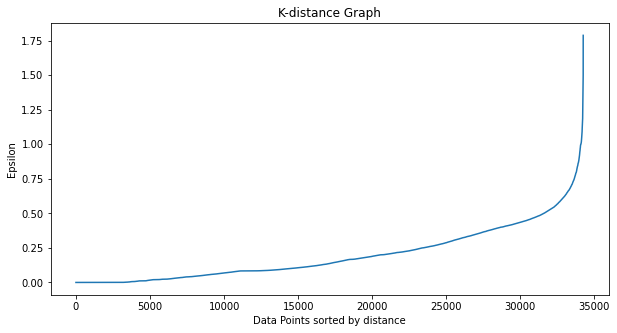

In [63]:
k_distance_plot(df, "minmax", 2)

# K-Means model

In [12]:
'''
    데이터프레임을 K-means 클러스터링 모델에 적용하여 차원 축소된 데이터와 클러스터 레이블을 반환합니다.

    Args:
        dataframe (pd.DataFrame): 입력 데이터프레임
        scaling_method (str): 스케일링 방법('standard', 'minmax', 'robust', 'unscaled')
        dim_reduction_method (str): 차원 축소 방법('PCA', 'TruncatedSVD')
        n_clusters (int): 클러스터의 개수
        n_components (int): 차원 축소 후의 컴포넌트 개수

    Returns:
        dim_red_data (np.ndarray): 차원 축소된 데이터
        cluster_labels (np.ndarray): 클러스터 레이블
'''

"\n    데이터프레임을 K-means 클러스터링 모델에 적용하여 차원 축소된 데이터와 클러스터 레이블을 반환합니다.\n\n    Args:\n        dataframe (pd.DataFrame): 입력 데이터프레임\n        scaling_method (str): 스케일링 방법('standard', 'minmax', 'robust', 'unscaled')\n        dim_reduction_method (str): 차원 축소 방법('PCA', 'TruncatedSVD')\n        n_clusters (int): 클러스터의 개수\n        n_components (int): 차원 축소 후의 컴포넌트 개수\n\n    Returns:\n        dim_red_data (np.ndarray): 차원 축소된 데이터\n        cluster_labels (np.ndarray): 클러스터 레이블\n"

In [13]:

# def KMeans_model(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components):
    
#     df_ohe = preprocess_cluster(dataframe)
    
#     # 전처리된 데이터프레임 준비
#     if scaling_method == 'standard':
#         preprocessing_model = StandardScaler()
#         data = preprocessing_model.fit_transform(df_ohe)
#     elif scaling_method == 'minmax':
#         preprocessing_model = MinMaxScaler()
#         data = preprocessing_model.fit_transform(df_ohe)
#     elif scaling_method == 'robust':
#         preprocessing_model = RobustScaler()
#         data = preprocessing_model.fit_transform(df_ohe)
#     elif scaling_method == 'unscaled':
#         data = df_ohe
    
#     # 차원 축소 모델 준비
#     if dim_reduction_method == "PCA":
#         dim_model = PCA(n_components=n_components)
#     elif dim_reduction_method == "TruncatedSVD":
#         dim_model = TruncatedSVD(n_components=n_components)

#     # 차원 축소
#     dim_reduce_data = dim_model.fit_transform(data)
    
#     # K-means 클러스터링
#     kmeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='auto', max_iter=300, random_state=0)
#     cluster_labels = kmeans.fit_predict(dim_reduce_data)
    
#     return dim_reduce_data, cluster_labels

In [64]:
def clustering_model(dataframe, method, scaling_method, dim_reduction_method, n_components, n_clusters, eps, min_samples):
    df_ohe = preprocess_cluster(dataframe)
    
    if scaling_method == 'standard':
        preprocessing_model = StandardScaler()
        data = preprocessing_model.fit_transform(df_ohe)
    elif scaling_method == 'minmax':
        preprocessing_model = MinMaxScaler()
        data = preprocessing_model.fit_transform(df_ohe)
    elif scaling_method == 'robust':
        preprocessing_model = RobustScaler()
        data = preprocessing_model.fit_transform(df_ohe)
    elif scaling_method == 'unscaled':
        data = df_ohe
    
    if dim_reduction_method == "PCA":
        dim_model = PCA(n_components=n_components)
    elif dim_reduction_method == "TruncatedSVD":
        dim_model = TruncatedSVD(n_components=n_components)
    
    dim_reduce_data = dim_model.fit_transform(data)
    
    if method == 'KMeans':
        clustering_model = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='auto', max_iter=300, random_state=0)
    elif method == 'DBSCAN':
        if eps is None or min_samples is None:
            raise ValueError("Both 'eps' and 'min_samples' must be provided for DBSCAN.")
        clustering_model = DBSCAN(eps=eps, min_samples=min_samples)
    elif method == 'MeanShift':
        best_bandwidth = estimate_bandwidth(dim_reduce_data, quantile=0.25)
        clustering_model = MeanShift(bandwidth=best_bandwidth, n_jobs=10)
    else:
        raise ValueError("Invalid clustering method specified.")
    
    cluster_labels = clustering_model.fit_predict(dim_reduce_data)
    
    return dim_reduce_data, cluster_labels


# Evaluation


In [65]:
def cluster_evaluaion(dataframe, method, scaling_method, dim_reduction_method, n_components, n_clusters, eps, min_samples):

    dim_reduce_data, cluster_labels = clustering_model(dataframe, method, scaling_method, dim_reduction_method, n_components, n_clusters, eps, min_samples)

    # Evaluation metrics
    silhouette_avg = silhouette_score(dim_reduce_data, cluster_labels)
    calinski_harabasz_avg = calinski_harabasz_score(dim_reduce_data, cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(dim_reduce_data, cluster_labels)

    # Entropy
    entopy = entropy(cluster_labels)

    return dim_reduce_data, cluster_labels, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg, entopy
    

# Visualization

In [66]:
def cluster_visualization(dataframe, method, scaling_method, dim_reduction_method, n_components, n_clusters, eps, min_samples):
    
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    dim_reduce_data, cluster_labels, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg, entopy = cluster_evaluaion(dataframe,method, scaling_method, dim_reduction_method, n_components, n_clusters, eps, min_samples)

    ax.scatter(dim_reduce_data[:, 0], dim_reduce_data[:, 1], dim_reduce_data[:, 2], c=cluster_labels)

    ax.set_title(#f'K-Means: {n_clusters} Clusters' +
                f'\nSilhouette Score: {silhouette_avg:.2f}' +
                f'\nCalinski Harabasz Score: {calinski_harabasz_avg:.2f}' +
                f'\nDavies Bouldin Score: {davies_bouldin_avg:.2f}' +
                f'\nEntropy: {entopy:.2f}')

    plt.tight_layout()
    plt.show()

# 군집 특징 파악

In [ ]:
# 군집별 df 만들기
def cluster_separation(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components):
    
    dim_reduce_data, cluster_labels, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg, entopy = cluster_evaluaion(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components)
    
    preprocessed_df = preprocess_cluster(dataframe)
    
    preprocessed_df['clusters'] = cluster_labels

    df_clusters = []  # 군집별 데이터프레임을 저장할 리스트

    for i in range(n_clusters):
        df_cluster = preprocessed_df[preprocessed_df['clusters'] == i]
        df_clusters.append(df_cluster)

    return df_clusters

#df_clusters[0]: 첫번째 군집에 해당하는 데이터프레임

In [ ]:
# 군집 중심점 계산 
def clusters_center(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components):
    
    df_clusters = cluster_separation(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components)
    preprocessed_df = preprocess_cluster(dataframe)
    
    cluster_stats = []

    for i, df_cluster in enumerate(df_clusters):
        cluster_stat = round(df_cluster.mean(), 2)
        cluster_stats.append(cluster_stat)

    cluster_stats.append(round(preprocessed_df.mean(), 2))  # 전체 데이터프레임의 평균도 추가

    cluster_labels = ['cluster_{}'.format(i+1) for i in range(n_clusters)] + ['dataframe']

    comparison = pd.DataFrame(cluster_stats, index=cluster_labels)

    return comparison

In [ ]:
# 변수별 군집 중심점 시각화
def compare_columns(comparison_df, columns):
    df_subset = comparison_df.loc[:, columns]
    df_subset = df_subset.transpose() 
    df_subset.plot(kind='bar', figsize=(2*len(columns), 4))
    plt.title('Comparison of feature statistics across clusters and big dataframe')
    plt.ylabel('Value')
    plt.xlabel('Feature')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
def cluster_center_visualize(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components):
    comparison = clusters_center(dataframe, scaling_method, dim_reduction_method, n_clusters, n_components)
    
    columns_to_compare = [
        ['hhd_collective_p', 'building_nonresidential_p', 'building_yeonlip_p', 'hhd_family_p', 'hhd_alone_p'],
        ['ppltn_adult_p', 'building_dasedae_p', 'building_dandok_p', 'hhd_private_p'],
        ['service_type_빌라', 'service_type_오피스텔', 'service_type_원룸'],
        ['aging', 'aged', 'post_aged'],
        ['room_direction_text_동향', 'room_direction_text_서향', 'room_direction_text_남향', 'room_direction_text_북향', 'room_direction_text_남동향', 'room_direction_text_남서향', 'room_direction_text_북동향', 'room_direction_text_북서향'],
        ['elevator', 'parking', 'building_apt_p'],
        ['gender_ratio', 'building_others_p'],
        ['safety_idx'],
        ['ppltn_foreign_domestic_ratio'],
        ['manage_cost_count'],
        ['corp_to_pop'],
        ['near_subways_count'],
        ['options_count'],
        ['_floor'],
        ['size_m2'],
        ['convenience_store_dist', 'school_dist', 'public_institution_dist', 'hospital_dist', 'supermarket_dist', 'subway_dist'],
        #['rent_adjusted'],
        ['ppltn_dnsty']
    ]

    for columns in columns_to_compare:
        compare_columns(comparison, columns)
    
